## Decentralized Cartography

In this notebook we will be gathering a random set of transactions using the [Ethereum ETL data located in bigquery](https://github.com/blockchain-etl/ethereum-etl) and clustering them base on their network interactions. Each non-contract wallet will be represented as a node, and each edge (aka connection) will be the distinct count of shared contracts the two wallets have with each other.

Clustering will be based off of [asynchronous label propogation](https://arxiv.org/pdf/0709.2938.pdf) for both its ability to scale and its interpretability.

The goal is to create a set of clusters that we can then offer to the user an unlabeled set of nodes and help the protocol determine what the cluster should be labeled as. Even being limited to a random set of addresses across 10 days worth of transactions, we can see clusters begin to form.

In [59]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

SQL_QUERY_FOR_BIGQUERY = '''
WITH users as (
SELECT
from_address,
to_address,
COUNT(DISTINCT t.hash) as weight
FROM `bigquery-public-data.crypto_ethereum.transactions` t
INNER JOIN `bigquery-public-data.crypto_ethereum.contracts` c ON c.address = t.to_address
LEFT JOIN `bigquery-public-data.crypto_ethereum.contracts` c1 on c1.address = t.from_address
WHERE DATE(t.block_timestamp) >= "2022-06-15"
AND c1.address IS NULL
GROUP BY 1,2
HAVING weight >= 10
)

SELECT
  a.from_address as user_a,
  b.from_address as user_b,
  STRING_AGG(DISTINCT a.to_address LIMIT 10) as shared_contracts,
  COUNT(DISTINCT a.to_address) as shared_contract_count
FROM users a 
INNER JOIN users b on b.to_address = a.to_address AND a.from_address != b.from_address
GROUP BY 1,2
HAVING shared_contract_count >= 5

'''

Data that was queried was exported locally to a csv. Schema was user_a, user_b, a list of 10 example contracts that they share, and the distinct count of all shared contracts within the given time frame.

In [60]:
# df = pd.read_csv('bquxjob_2724e0a8_1819ba70931 (1).csv') This was the first approach where all contracts were nodes as well.
df = pd.read_csv('network_v2_limited.csv.csv')
df.rename({'shared_contract_count': 'weight'}, axis=1, inplace=True)
df.head()

,user_a,user_b,shared_contracts,weight
0,0x61317c73d0225b2e37140fb9664d607b450613c6,0x218b5a7861dbf368d09a84e0dbff6c6ddbf99db8,"0xb864d98a8d5f16d41f021a5ba9d3d26e78d0d1fa,0xd...",44
1,0xce859e48f6ce9834a119ba04fdc53c1d4f1082a7,0xf16e77a989529aa4c58318acee8a1548df3fccc1,"0x9565b54d720656508b14d3d19ab45e462a01338d,0x6...",25
2,0xb976d01275b809333e3efd76d1d31fe9264466d0,0x982fa4d5f5c8c0063493abe58967ca3b7639f10f,"0x68577f915131087199fe48913d8b416b3984fd38,0xa...",25
3,0x28c6c06298d514db089934071355e5743bf21d60,0x75e89d5979e4f6fba9f97c104c2f0afb3f1dcb88,"0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0x6...",57
4,0xcc29be4ca92d4ecc43c8451fba94c200b83991f6,0x218b5a7861dbf368d09a84e0dbff6c6ddbf99db8,"0x568b8fd03992f56bf240958d22f5a6fcf7bd850b,0x6...",36


In total, we have around 291 unique wallets to work with for clustering.

In [61]:
# len(set(list(df['from_address']) + list(df["to_address"])))
len(set(list(df['user_a']) + list(df["user_b"])))

291

Using this dataset, we build a graph using networkx

In [62]:
# G = nx.from_pandas_edgelist(df, source="from_address", target="to_address", edge_attr=["weight"])
G = nx.from_pandas_edgelist(df, source="user_a", target="user_b", edge_attr=["weight"])

Use Asynchronous Label Propogation to cluster nodes depending on their wallet interactions

In [63]:
# clusters = nx.algorithms.community.asyn_lpa_communities(G, weight='weight')
clusters = nx.algorithms.community.asyn_lpa_communities(G, weight='weight')

c_list = list(clusters)

In [64]:
labels = {}
for a,b in enumerate(c_list):
    labels[a] = b

Out of 291 wallets, we've created 12 clusters to examine. In our application we would show these clusters to the user along with some additional information to help with labeling

In [65]:
len(labels)

12

### Example 1 

In the first cluster, we identified a collection of wallets transmitting data to Chainlink oracles. Hence the near complete graph of wallets that share similar smart contract interactions

In [109]:
list(labels[0])[:10]

['0xf16e77a989529aa4c58318acee8a1548df3fccc1',
 '0xb976d01275b809333e3efd76d1d31fe9264466d0',
 '0xbbf078a8849d74623e36e6dbbdc8e0a35e657c26',
 '0x9e1735d07f77aba85415fbe19fdb371a56cabf07',
 '0xa938d77590af1d98bab7dc4a0bde594fc3f9c403',
 '0x7bfb89db2d7217c57c3ad3d4b55826efd17dc2e9',
 '0xc61a7e5a04a5d32ffe8e01f77cb39253bf21d2ac',
 '0xfa0e4f48a369bb3ecbcee0b5119379ea8d1bcf29',
 '0x9741569dedb1e0cb204f2df7f43f7a52bb49ba3a',
 '0x8b1d49a93a84b5da0917a1ed42d8a3e191c28524']

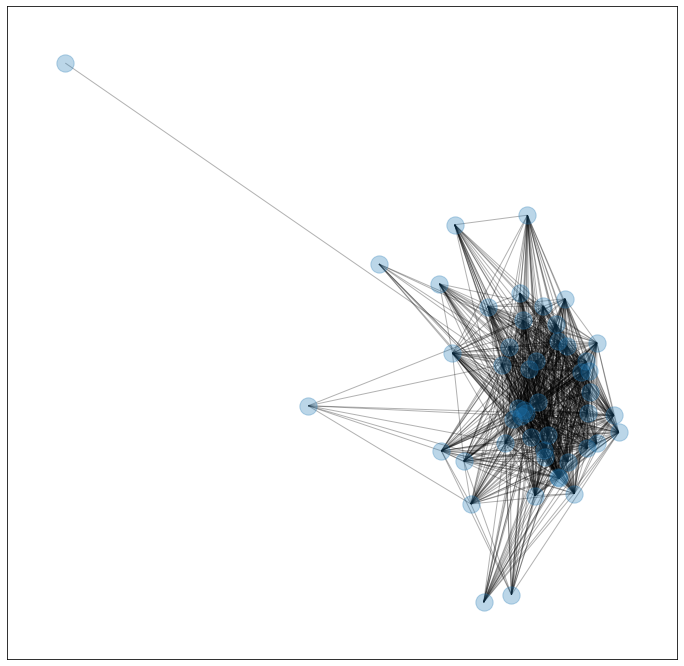

In [85]:
plt.figure(figsize=(12,12))
nx.draw_networkx(G.subgraph(list(labels[0])), with_labels=False, alpha=0.3, pos=nx.spring_layout(G, weight='weight'))

### Example 2 

Within this cluster, we can see a near complete network of nodes that have similar contract interactions. Looking at the first 10 wallets, it becomes apparent that they all seem to be defi traders using paraswap, 1inch, and cross-chain bridges

In [89]:
list(labels[3])[:10]

['0x8594d8e9483473626908648a5539d9d65ca2fe8d',
 '0x7a6a59588b8106045303e1923227a2cefbec2b66',
 '0x5596d991bf7753f0f14e1c5b59abbea626725401',
 '0x65a8f07bd9a8598e1b5b6c0a88f4779dbc077675',
 '0xd54e4f8a55247487dd7c8c59f14ee5c0c2889477',
 '0xf4484efb942029b1535eb55d3858145bd6c2a2bc']

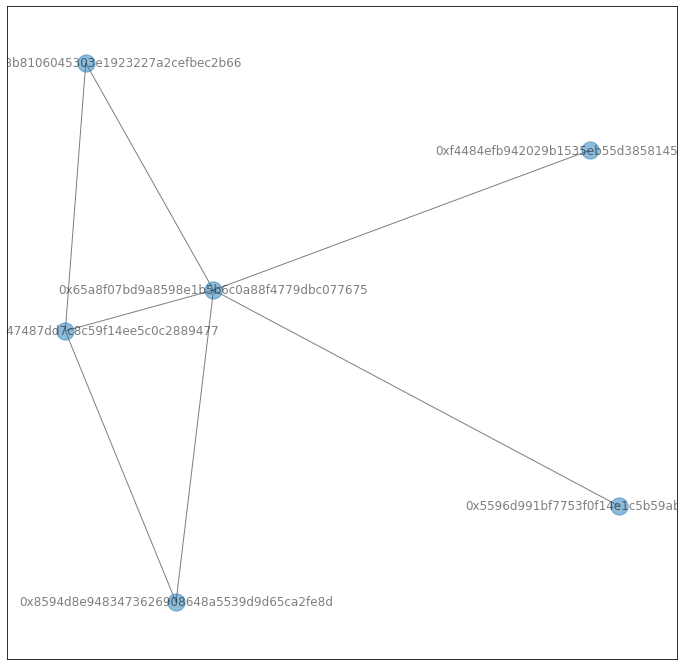

In [108]:
plt.figure(figsize=(12,12))

nx.draw_networkx(G.subgraph(list(labels[3])), with_labels=True, alpha=0.5, pos=nx.spring_layout(G, weight='weight'))